# **COLORAZIONE AUTOMATICA DI IMMAGINI: CGAN (PIX2PIX)**
---

#Introduzione

In questo notebook si andrà ad affrontare il problema della colorazione automatica di immagini in bianco e nero tramite una variante delle Generative Adversarial Networks (GAN): le Conditional Gan (cGAN).

## Che cosa sono le GAN e cosa cambia nella Conditional Gan ?
Le GAN sono modelli generativi che imparano a creare immagini realistiche, spingendo il generatore a produrre output sempre più convincenti per ingannare un discriminatore addestrato a riconoscere i falsi.

In una cGAN invece, sia il generatore che il discriminatore ricevono un input di condizionamento: nel nostro caso, l’immagine in bianco e nero. Il generatore impara a colorare l'immagine in modo realistico, mentre il discriminatore valuta se il risultato è credibile rispetto alle immagini reali.

L'architettura scelta e sviluppata in questo notebook è più precisamente quella di una Pix2Pix.

## Qual è la struttura di un cGAN Pix2Pix ?
Il generatore di Pix2Pix è basato sulla U-Net, una rete encoder–decoder con skip connection che collegano direttamente i livelli corrispondenti dell’encoder e del decoder, permettendo di preservare dettagli spaziali importanti. L’encoder comprime l’immagine in una rappresentazione compatta attraverso convoluzioni e attivazioni LeakyReLU, mentre il decoder la ricostruisce con convoluzioni trasposte e dropout. L’output finale è normalizzato tra -1 e 1 tramite una funzione di attivazione tanh, motivo per cui anche le immagini di input sono preprocessate su questo intervallo.

Il discriminatore adotta invece l’approccio PatchGAN, che non valuta l’intera immagine ma analizza separatamente piccole patch locali, classificandole come reali o generate. Questo rende il modello particolarmente efficace nel cogliere dettagli e texture, migliorando la qualità delle immagini prodotte. Anche il discriminatore è una rete convoluzionale profonda, con blocchi che combinano convoluzioni, normalizzazione e attivazioni LeakyReLU.

# Inclusione delle librerie utili

In [ ]:
from google.colab import drive, files
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.src import saving
import pandas as pd
import numpy as np
import os

In [ ]:
#@title Montaggio Drive
try:
    drive.mount('/content/drive')
    print("Google Drive montato con successo.")
except Exception as e:
    print(f"Errore durante il montaggio di Google Drive: {e}")
    exit()

Mounted at /content/drive
Google Drive montato con successo.


#Caricamento del dataset preprocessato

Prima di definire le architetture, è necessario caricare i dati pre-processati in formato `.npy`, così da evitare di ripetere il pre-processing. Questi file sono stati generati nel notebook [database_management.ipynb](https://colab.research.google.com/drive/1RlXQHRaDaFujpfJ_Oi_xRBpPUqNYXK2W).

In [ ]:
color_img = np.load('/content/drive/MyDrive/DL_project/processed_dataset/GAN/color_img_GAN.npy')
gray_img = np.load('/content/drive/MyDrive/DL_project/processed_dataset/GAN/gray_img_GAN.npy')

# Per assicurarci che i dati siano stati importati correttamente, visualizziamo le dimensioni (shape) di ciascun array caricato.
print(f"Shape immagini a colori prima della reshape: {color_img.shape}")
print(f"Shape immagini in scala di grigio prima della reshape: {gray_img.shape}")

Shape immagini a colori prima della reshape: (7129, 256, 256, 3)
Shape immagini in scala di grigio prima della reshape: (7129, 256, 256, 1)


#Suddivisione del dataset in train, test e validation


Per l'organizzazione dei nostri set di dati effettuiamo una chiamata a `train_test_split()`.

Separeriamo i dati nei due set fondamentali per l'apprendimento automatico: il set di addestramento (training), su cui il modello imparerà, e il set di test che utilizzeremo per verificare come lavora il modello con dati mai visti prima d'ora.

*È importante notare che questa sequenza di passaggi di suddivisione dovrà essere applicata coerentemente sia al set di immagini a colori che a quello in scala di grigi, assicurando la corretta corrispondenza tra input e output in tutte le fasi di training e test.*

In [ ]:
# Effettuiamo la chiamata a train_test_split con un random_state prefissato in modo da rendere ripetibile
# l'output e garantire che lo shuffle dei dati prima dello split sia sempre uguale

# Teniamo come set di test un 20% delle immagini del dataset
X_gray_train, X_gray_test, y_color_train, y_color_test = train_test_split(gray_img, color_img, test_size=0.2, random_state=21)


# Verifichiamo ora le shape dei rispettivi set per verificare la corretta suddivisione
print(f"X_gray_train (immagini di training in scala di grigio): {X_gray_train.shape}")
print(f"y_color_train (immagini di training a colori): {y_color_train.shape}")
print(f"X_gray_test (immagini di test in scala di grigio): {X_gray_test.shape}")
print(f"y_color_test (immagini di test a colori): {y_color_test.shape}")

X_gray_train (immagini di training in scala di grigio): (5703, 256, 256, 1)
y_color_train (immagini di training a colori): (5703, 256, 256, 3)
X_gray_test (immagini di test in scala di grigio): (1426, 256, 256, 1)
y_color_test (immagini di test a colori): (1426, 256, 256, 3)


# Colorization cGAN - Pix2Pix

Per costruire questo autoencoder, definiamo due funzioni fondamentali: **`downsample`** e **`upsample`**.

La funzione **`downsample`** è implementata come un blocco `Sequential()`. Al suo interno, il primo strato è un `Conv2D()` con `strides=2`, che opera la riduzione della dimensione spaziale. Per stabilizzare l'addestramento e facilitare la backpropagation, i pesi di questo strato vengono **inizializzati** utilizzando una **distribuzione normale**, una pratica comune *suggerita in letteratura scientifica*.

È stata inoltre parametrizzata l'inclusione opzionale di un livello **`BatchNormalization()`**, seguito da una funzione di attivazione **`LeakyRelu()`**. L'adozione della **`LeakyRelu()`**al posto della più comune **`ReLU()`** è mirata a mitigare il problema della **"morte" dei neuroni**, introducendo una **pendenza negativa** che **favorisce** la **discesa dei gradienti** anche per input negativi.

Analogamente, la funzione **`upsample`** è anch'essa definita come un blocco **`Sequential()`**. Il suo componente principale è un **`Conv2DTranspose()`** con **`strides=2`**, responsabile dell'aumento della dimensione spaziale. I kernel di questo strato sono inizializzati con la medesima distribuzione normale utilizzata nel downsample. Questo strato è seguito da un livello **`BatchNormalization()`**. È stata prevista la possibilità di applicare un livello di **`Dropout()`** con una percentuale del 50% per promuovere la regolarizzazione del modello, dopodiché viene applicata la funzione di attivazione **`ReLU()`**.

In [ ]:
# Definizione della dimensionalità di output
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

##Generatore


Di seguito viene descritta nel dettaglio la **struttura del generatore** della **cGAN**, costruito seguendo l’**architettura U-Net** citata prima. Dopo aver definito le funzioni di **downsample** e **upsample**, passiamo alla costruzione vera e propria del generatore tramite la funzione **`Generator()`**.

Il **generatore** prende in ingresso **immagini** in **scala di grigi**, come specificato dal primo livello **`Input(shape=[256, 256, 1])`**. A partire da questo input, viene creato uno **stack** di **downsampling** composto da **5 blocchi**, memorizzati all’interno di una lista Python. Il primo blocco è definito con `apply_batchnorm=False`, evitando così l'applicazione della normalizzazione nel primo livello, mentre nei successivi quattro blocchi la normalizzazione è attiva di default. Questi livelli hanno lo scopo di comprimere progressivamente l'informazione, riducendo la dimensione spaziale e aumentando il numero di feature.

Lo **stack** di **upsampling** segue simmetricamente, composto da **4 blocchi upsample**, ognuno dei quali ha il compito di ricostruire l'immagine riportandola alle dimensioni originali. Ogni livello upsample prevede l'applicazione di **`Conv2DTranspose()`**, **`BatchNormalization()`**, opzionalmente **`Dropout()`**, e infine attivazione **`ReLU()`**.

Alla fine del percorso di decodifica, l'ultimo livello è rappresentato da un **Conv2DTranspose** con attivazione **tanh**, **strides=2** e **inizializzazione** tramite **random_normal_initializer**.

*Questo livello ha l'obiettivo di produrre l’immagine finale ricostruita, con dimensioni 256x256 e 3 canali.*

Durante il processo di downsampling, i risultati intermedi vengono salvati in una lista chiamata **skips**. Questi serviranno per realizzare le **skip connection**, che vengono poi applicate durante l’**upsampling**. Per farlo, si itera parallelamente sui blocchi up_stack e sugli elementi della lista skips (invertiti tranne l’ultimo), concatenando i rispettivi tensori attraverso il layer `Concatenate()`.

*Questo tipo di concatenazione risulta più indicato rispetto ad altre operazioni (come Add) perché consente di preservare completamente le feature provenienti dall’encoder, arricchendo le rappresentazioni durante la fase di ricostruzione.*

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
  ]

  up_stack = [
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Effettuiamo il downsampling iterando sullo stack e salvando i risultati dei vari livelli in una lista che useremo per le skip connection
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])



  # Effettuiamo l'upsampling iterando sullo stack e applicando con Concatenate le skip connection
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

istanziamo un generatore

In [ ]:
generator = Generator()
generator.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      1,024 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 16, 16,    │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ sequential_5[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 32, 32,    │  4,195,328 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ sequential_6[0][… │
│ (Concatenate)       │ 512)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 64, 64,    │  1,049,088 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 256)              │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 128, 128,  │    262,400 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 128)              │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 256, 256,  │      6,147 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,662,787 (63.56 MB)

 Trainable params: 16,658,051 (63.55 MB)

 Non-trainable params: 4,736 (18.50 KB)

La funzione di loss del generatore combina **due componenti fondamentali**. La prima è la cosiddetta **GAN loss**, *che misura quanto efficacemente il generatore riesce a ingannare il discriminatore*.

In pratica, questa parte della loss viene calcolata come una **Binary Crossentropy** tra un vettore di valori attesi pari a uno (che rappresentano immagini reali) e l'output del discriminatore applicato alle immagini generate. Grazie all'opzione **from_logits=True**, questa funzione si comporta come una ***Sigmoid Cross Entropy***, *come comunemente adottato nei modelli GAN*.

Alla **GAN loss** viene sommata una *seconda componente*, l’**L1 loss**, che corrisponde alla **differenza assoluta media** tra l’**immagine generata** e quella **reale** (non è altro che un **MAE** - errore medio assoluto).

Questo termine (L1) ha il compito di **guidare** il **generatore** a produrre immagini visivamente più **fedeli** al **target originale**, contribuendo alla **qualità strutturale** del risultato.

Infine, la **loss totale** del generatore è ottenuta combinando i due termini: alla GAN loss si aggiunge l’**L1 loss** moltiplicata per **LAMBDA** (valore è stato deciso dagli autori dell'articolo), che in questo caso è impostato a 100.

In [ ]:
LAMBDA = 100
# Impostando from_logits = True utilizziamo di fatto una Sigmoid Cross Entropy
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss(disc_generated_output, gen_output, target):
  # Calcola la sigmoid cross entropy (loss_object è una binary cross entropy, con from_logits=True diventa sigmoidea)
  # tf.ones_like(disc_generated_output) = le label reali
  # disc_generated_output = output predetto dal generatore
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

##Discriminatore

Di seguito viene descritta nel dettaglio la struttura del discriminatore della cGAN, costruito per distinguere tra immagini reali e generate. Il discriminatore adotta un’architettura simile a quella di un PatchGAN, in cui l’output non è una singola etichetta binaria, ma una mappa di valori che valuta localmente quanto sia reale ciascun patch dell’immagine.

Il modello prende in ingresso due immagini: l’immagine di input (ad esempio in scala di grigi) e l’immagine target, che può essere reale (ground truth) o generata dal generatore. I due tensori vengono concatenati lungo l’asse dei canali **`(axis=-1)`** tramite il livello Concatenate, ottenendo così un unico tensore di forma **[256, 256, 6] (3 canali + 3 canali)**. Questa concatenazione consente al discriminatore di confrontare direttamente l’immagine di partenza con l’immagine di destinazione o generata.

Successivamente viene applicata una serie di tre blocchi `downsample`, realizzati tramite la funzione downsample, ognuno dei quali applica una convoluzione con stride 2, seguita da una normalizzazione (BatchNormalization) e una funzione di attivazione LeakyReLU. Questi strati hanno il compito di estrarre feature sempre più astratte e profonde riducendo gradualmente la dimensione spaziale.

Dopo il downsampling, viene applicato un livello di **`ZeroPadding2D`**, che aggiunge un bordo di zeri attorno all’immagine per mantenere le dimensioni compatibili con la successiva convoluzione. A questo punto viene applicata una convoluzione con **512 filtri**, kernel di dimensione 4 e **`stride=1`**, seguita da una BatchNormalization e da una LeakyReLU, che introduce non-linearità mantenendo l’informazione anche per input negativi.

Segue un secondo livello di ZeroPadding2D, utile per allineare le dimensioni prima dell’ultimo layer convoluzionale, che ha il compito di produrre l’output finale: una mappa di attivazione di dimensione **[30, 30, 1]**, ottenuta tramite **`Conv2D`** con un solo filtro e **kernel di dimensione 4**. Ciascun elemento di questa mappa rappresenta il punteggio che indica quanto ciascuna patch dell’immagine viene classificata come reale (proveniente dai dati) o falsa (prodotta dal generatore).

Ogni elemento di questa mappa corrisponde a un punteggio che quantifica quanto una specifica porzione dell'immagine appaia realistica o artificiale, creando così una valutazione dettagliata della qualità dell'immagine analizzata.

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [ ]:
discriminator = Discriminator()
discriminator.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 128, 128,  │      6,144 │ concatenate_4[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 64, 64,    │    131,584 │ sequential_9[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 32, 32,    │    525,312 │ sequential_10[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ sequential_11[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 31, 31,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_8[0]… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,770,433 (10.57 MB)

 Trainable params: 2,768,641 (10.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

La funzione di loss del discriminatore ha il compito di misurare quanto bene il modello riesce a distinguere tra immagini reali e immagini generate.


In particolare, la funzione accetta in ingresso due elementi fondamentali:
- **`disc_real_output`**: rappresenta l’output del discriminatore quando riceve in input una coppia reale di immagini (input + immagine target vera);

- **`disc_generated_output`**: rappresenta l’output del discriminatore quando riceve in input una coppia falsa (input + immagine generata dal generatore).



Per valutare le prestazioni, si calcolano due componenti:

La **`real_loss`** è una **binary cross-entropy** (entropia incrociata binaria) tra un array di 1 (che è l'etichetta che rappresenta il "vero") e l’output del discriminatore applicato alle immagini reali.
Serve a valuatare quanto il discriminatore è in grado di riconoscere le immagini reali come tali.
Si usa **`tf.ones_like(disc_real_output)`** per creare un tensore di target positivo (1).


La **`generated_loss`** è anch'essa una **binary cross-entropy**, ma stavolta tra un array di 0 (che è l'etichetta che rappresenta il "falso") e l’output del discriminatore sulle immagini generate.
Serve a misurare quanto il discriminatore riesce a identificare correttamente le immagini false. Si usa **`tf.zeros_like`**(disc_generated_output) per creare un tensore di target negativo (0).

Le due perdite vengono poi sommate per ottenere la perdita totale del discriminatore (total_disc_loss)
Questa somma rappresenta l’errore complessivo del discriminatore: più è bassa, più il modello sta riuscendo a distinguere correttamente immagini reali da immagini false.

Lo scopo del discriminatore durante l’addestramento è quindi minimizzare questa loss totale, migliorando continuamente la sua capacità di riconoscere le immagini reali come autentiche (real_loss bassa) e identificare le immagini generate come false (generated_loss bassa).

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):

  # Il compito del discriminatore è minimizzare 2 loss: deve essere 'bravo' a distinguere quelle reali da quelle false e viceversa.

  #Calcola quanto il discriminatore sta riconoscendo correttamente un'immagine reale
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  #Calcola quanto il discriminatore sta riuscendo a riconoscere l'immagine generata come fake
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Definizione degli ottimizzatori

In [ ]:
gan_path = "/content/drive/MyDrive/DL_project/GAN"
os.makedirs(gan_path, exist_ok=True)

Vengono definiti **due ottimizzatori Adam** identici, uno per il **generatore** e uno per il **discriminatore**, con **learning rate** pari a **2e-4** e **parametro beta_1** impostato a **0.5**.

*Questa configurazione è ispirata direttamente dal paper Pix2Pix ed è frutto di pratiche consolidate nell’addestramento delle reti GAN.*

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

Poiché l'applicazione di un metodo fit tradizionale non è fattibile, abbiamo implementato una funzione **fit customizzata**. Questa funzione **accetta** il **set di addestramento**, composto da **immagini in scala di grigio** (**`x_train`**) e le corrispondenti **immagini target a colori** (**`y_train`**), oltre al **numero di epoche**.

All'interno della **funzione fit**, definiamo una **`batch_size`** e creiamo un **`tf.data.Dataset`** di coppie (x, y) che viene poi diviso in batch della dimensione specificata. Per ogni epoca, la **loss** del **generatore** e del **discriminatore** viene **inizializzata a zero** per un calcolo cumulativo. Manteniamo una variabile **`best_loss`** inizializzata a **infinito**, in modo che venga **progressivamente aggiornata** con la ***media della loss del generatore più bassa*** riscontrata fino a quel momento.

Durante il ciclo di addestramento interno, iteriamo attraverso i batch del dataset. Ad ogni **`train_step`**, **calcoliamo** e **accumuliamo** le loss del **generatore** e del **discriminatore**. Una volta elaborati tutti i batch, **calcoliamo la media delle loss** per l'epoca dividendo la **somma cumulativa** per il **numero totale di step**. Le medie vengono quindi stampate per monitorare l'andamento dell'addestramento.

Per ottener una history, abbiamo definito **due liste**, **`gen_loss_list`** e **`disc_loss_list`**, alle quali **aggiungiamo iterativamente** le **loss medie calcolate** alla **fine di ogni epoca**.

Le due **liste** vengono poi **restituite** dalla **funzione fit**, **emulando** il comportamento di una *fit tradizionale*.

*Infine, la migliore loss media del generatore viene utilizzata come criterio per salvare i modelli del generatore e del discriminatore, garantendo che vengano conservate solo le versioni che hanno dimostrato la performance più elevata.*

In [ ]:
def fit(x_train, y_train, epochs):
  gen_loss_list = []
  disc_loss_list = []

  best_loss = float('inf')
  batch_size = 32
  train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

  num_steps_per_epoch = (len(x_train) + batch_size - 1) // batch_size  # Calcoliamo il numero di steps per epoca approssimando verso l'alto

  for epoch in range(epochs):
      print("Epoch: ", epoch + 1)
      epoch_loss_gen = 0
      epoch_loss_disc = 0
      steps = 0

      for input_image, target in train_dataset:
          generator_loss, discriminator_loss = train_step(input_image, target, epoch)
          epoch_loss_gen += float(generator_loss)
          epoch_loss_disc += float(discriminator_loss)
          steps += 1

          # stampiamo la progressione degli steps
          if steps % batch_size == 0 or steps == num_steps_per_epoch:
              print(f"  Step {steps}/{num_steps_per_epoch}")

      avg_loss_gen = epoch_loss_gen / steps
      avg_loss_disc = epoch_loss_disc / steps
      print(f"Average generator loss: {avg_loss_gen:.4f}")
      print(f"Average discriminator loss: {avg_loss_disc:.4f}")

      gen_loss_list.append(avg_loss_gen)
      disc_loss_list.append(avg_loss_disc)

      # se la loss media del generatore è minore di quella dell'epoca precedente salviamo entrambi i modelli
      # Utilizziamo come criterio la total_gen_loss perché include già l’equilibrio tra GAN loss e L1 loss
      if avg_loss_gen < best_loss:
          best_loss = avg_loss_gen
          generator.save(os.path.join(gan_path, "best_gen_model.keras"))
          discriminator.save(os.path.join(gan_path, "best_disc_model.keras"))
          print(f"Nuovo modello salvato con loss {best_loss:.4f}")

      print()

  return gen_loss_list, disc_loss_list


La funzione **`train_step`** costituisce il **nucleo centrale** del processo di addestramento della cGAN. A ogni invocazione **riceve** una **coppia di immagini**: l’**input in scala di grigio** e il **target corrispondente** a **colori**. All’interno di due distinti **`GradientTape`**, utilizzati per **registrare** separatamente i **gradienti** del **generatore** e del **discriminatore**, viene eseguita una **forward pass**: il **generatore** crea una **versione colorata** a partire dall’immagine in scala di grigi, mentre il **discriminatore** valuta sia la **coppia reale (input e target)** sia quella **generata (input e output del generatore)**.

Poiché il discriminatore opera su immagini RGB, **convertiamo** l’immagine in scala di grigi a **tre canali** tramite **`tf.image.grayscale_to_rgb`**. Successivamente, vengono calcolate le rispettive funzioni di perdita: la **loss del generatore**, composta dalla **GAN loss** e dalla **L1 loss**, e la **loss del discriminatore**.

*Infine, si calcolano i gradienti e si aggiornano i pesi dei due modelli usando gli ottimizzatori definiti. La funzione restituisce la loss totale del generatore e quella del discriminatore, utili per monitorare l’andamento dell’addestramento epoca dopo epoca.*

In [ ]:
@tf.function
def train_step(input_image, target, epoch):

    # Utilizziamo due GradientTape diversi per salvare separatamente i gradienti di generatore e discriminatore in modo da poterli recuperare e aggiornare
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Passiamo l'immagine in scala di grigi e ne facciamo generare una colorata (fake) al generatore
        gen_output = generator(input_image, training=True)

        # Convertiamo la shape dell'immagine in scala di grigi in modo che combaci con le dimensioni che si aspetta in input il discriminatore
        input_image = tf.image.grayscale_to_rgb(input_image)

        # Passiamo le immagini reali e false al discriminatore con le corrispettive immagini a colori e ci salviamo gli output
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        # Calcoliamo le loss
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Effettuiamo il calcolo dei gradienti
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Applichiamo gli aggiornamenti
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, disc_loss


In [ ]:
gen_loss_list, disc_loss_list = fit(X_gray_train, y_color_train, epochs = 50)

Epoch:  1
  Step 32/179
  Step 64/179
  Step 96/179
  Step 128/179
  Step 160/179
  Step 179/179
Average generator loss: 15.2141
Average discriminator loss: 1.2590
Nuovo modello salvato con loss 15.2141

Epoch:  2
  Step 32/179
  Step 64/179
  Step 96/179
  Step 128/179
  Step 160/179
  Step 179/179
Average generator loss: 12.6550
Average discriminator loss: 1.1041
Nuovo modello salvato con loss 12.6550

Epoch:  3
  Step 32/179
  Step 64/179
  Step 96/179
  Step 128/179
  Step 160/179
  Step 179/179
Average generator loss: 12.3647
Average discriminator loss: 1.0796
Nuovo modello salvato con loss 12.3647

Epoch:  4
  Step 32/179
  Step 64/179
  Step 96/179
  Step 128/179
  Step 160/179
  Step 179/179
Average generator loss: 12.1449
Average discriminator loss: 1.0834
Nuovo modello salvato con loss 12.1449

Epoch:  5
  Step 32/179
  Step 64/179
  Step 96/179
  Step 128/179
  Step 160/179
  Step 179/179
Average generator loss: 11.9686
Average discriminator loss: 1.1092
Nuovo modello salvat

#Salvataggio della history del modello

Creiamo un **`DataFrame`** per salvare lo **storico delle loss** raccolte durante l’addestramento. A questo scopo, definiamo un **dizionario** in cui le **chiavi** rappresentano i **nomi delle metriche** (ad esempio, la loss del generatore e del discriminatore) e i **valori** corrispondono alle rispettive **liste contenenti i valori registrati epoca per epoca**, restituite dalla funzione **fit**.

In [ ]:
# Salviamo la history del modello passando li liste delle loss ottenute con la fit e le passiamo come dizionario a pd.DataFrame che non accetta due liste coe argomento
df_history_gan_RGB = pd.DataFrame({'generator_loss': gen_loss_list,'discriminator_loss': disc_loss_list})

# Salviamo in un file CSV, nella cartella `GAN`
df_history_gan_RGB.to_csv(os.path.join(gan_path, 'gan_training_log_RGB.csv'), index=False)

## Caricamento miglior modello

In [ ]:
generator_path = os.path.join(gan_path, 'best_gen_model.keras')
# Verifica che il file (contenente il miglior modello di generatore) esista prima di caricarlo in `best_generator`
if generator_path:
    print(f'Caricamento del miglior modello dal path: {generator_path}')

    # Carica il modello con i pesi dell'epoca migliore registrata durante il training
    best_generator = tf.keras.models.load_model(generator_path)

else:
    print(f"Errore: Il file del miglior modello non è stato trovato a {generator_path}")

Caricamento del miglior modello dal path: /content/drive/MyDrive/DL_project/GAN/best_gen_model.keras


## Valutazione sul test e Stampa delle predizioni

Una volta caricato il modello più performante, definiamo la funzione per il calcolo dell'**SSIM** (*Structural Similarity Index Measure*).

Successivamente, eseguiamo la **predizione** sul **set di test**, composto da immagini in scala di grigio (**`X_gray_test`**).

*Le predizioni così ottenute vengono poi passate alla funzione della metrica di valutazione, che calcola e restituisce lo score SSIM finale, indicativo delle prestazioni del modello in fase di validazione.*

In [ ]:
def compute_ssim_batch(y_true, y_pred, max_val=1.0):
    ssims = []
    for i in range(len(y_true)):
        ssim = tf.image.ssim(y_true[i], y_pred[i], max_val=max_val)
        ssims.append(ssim)
    return tf.reduce_mean(ssims)

In [ ]:
print('Valutazione modello su set di test RGB:')
pred_rgb = best_generator.predict(X_gray_test)
ssim_rgb = compute_ssim_batch(y_color_test, pred_rgb)

print(f'SSIM (RGB): {ssim_rgb.numpy():.4f}')

Valutazione modello su set di test RGB:
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step
SSIM (RGB): 0.7628


Creiamo una **funzione** per **denormalizzare** i valori delle immagini che sono ancora in un **range [-1,1]** e un'altra per **stampare** i **risultati** delle **predizioni del modello**.

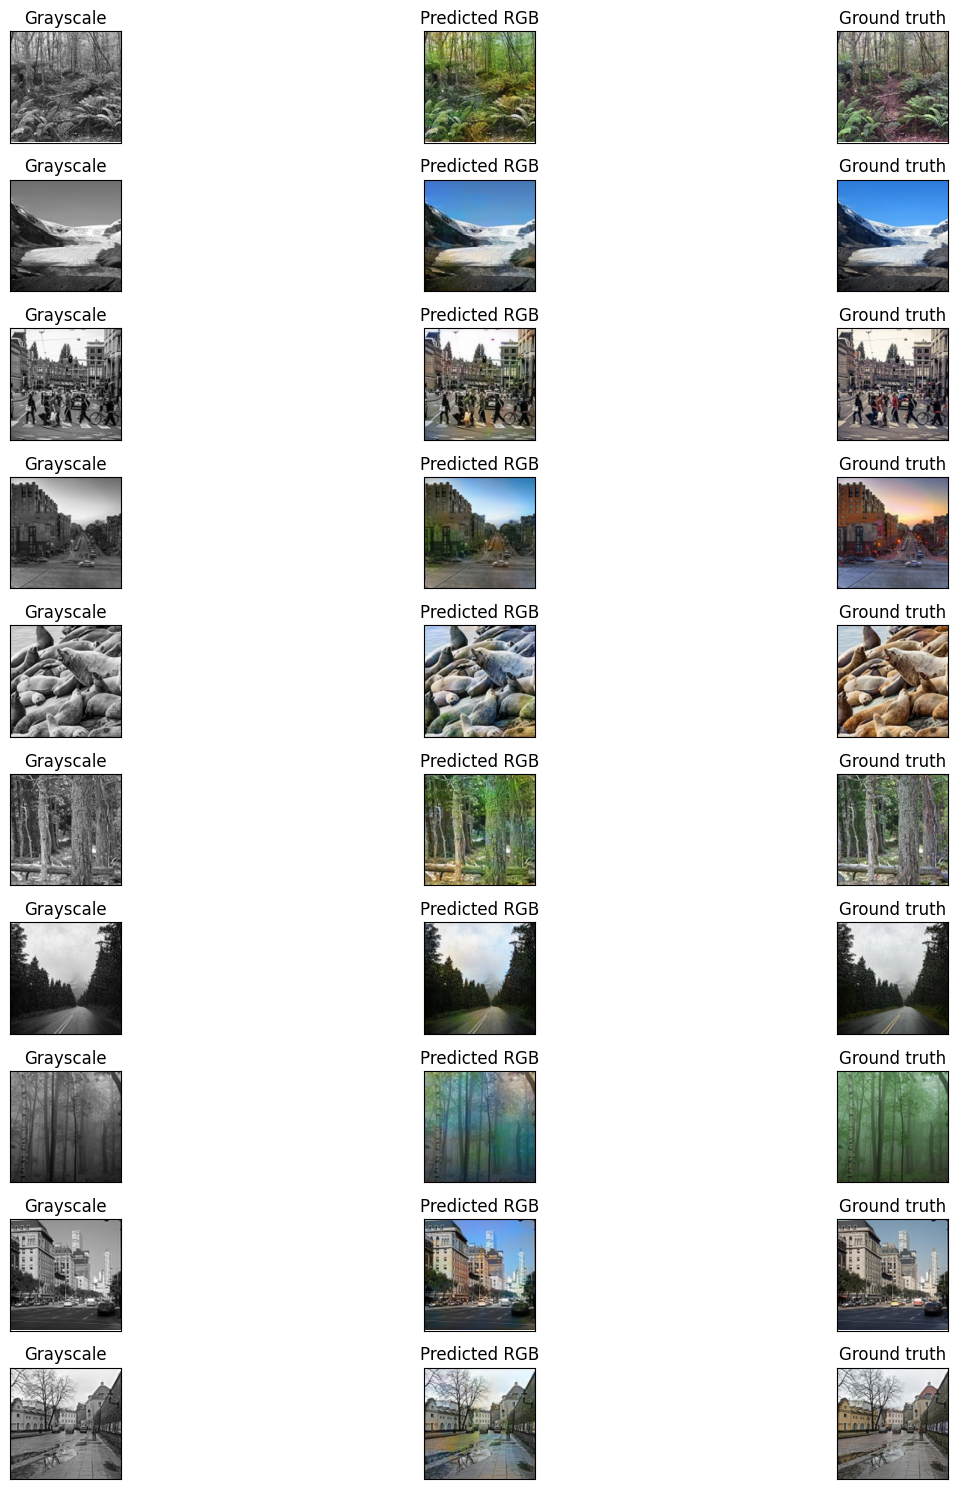

In [ ]:
# Creiamo una funzione che denormalizzi le immagini e ci permetta di vedere i colori reali RGB
def denormalize(img):
    # Passiamo da un range di [-1, 1] a un range di [0, 1] per una corretta visualizzazione
    return (img + 1) / 2.0

def plot_results(model, test_input, tar, i):
    # Aggiungiamo la dimensione del batch per effettuare l'inferenza
    prediction = model(tf.expand_dims(test_input, 0), training=False)

    # Denormalizzaziamo tutte le immagini
    input_img = denormalize(test_input)
    target_img = denormalize(tar)
    pred_img = denormalize(prediction[0])

    # Input: immagini in scala di grigio (1 canale)
    ax = plt.subplot(10, 3, 3*i + 1)
    plt.imshow(input_img.reshape(256, 256), cmap='gray')
    plt.title("Grayscale")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # Output del modello codifica RGB: immagini colorate (3 canali)
    ax = plt.subplot(10, 3, 3*i + 2)
    plt.imshow(pred_img)
    plt.title("Predicted RGB")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # Immagini reali a colori (3 canali)
    ax = plt.subplot(10, 3, 3*i + 3)
    plt.imshow(target_img)
    plt.title("Ground truth")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

n = 10
plt.figure(figsize=(15, 15))
for i in range (n):
  example_input = X_gray_test[i]
  example_target = y_color_test[i]
  plot_results(generator, example_input, example_target, i)

plt.tight_layout()
plt.show()

Mostriamo ora l’**andamento delle loss** del **generatore** e del **discriminatore** durante le **50 epoche** di addestramento.



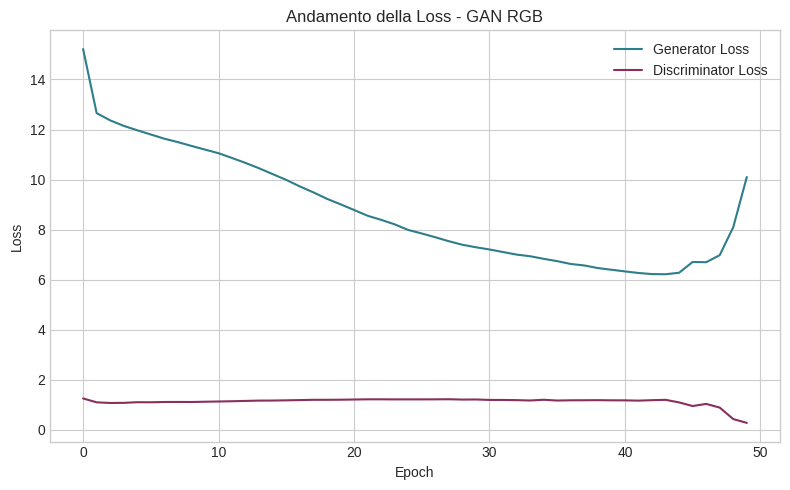

In [ ]:
df_history_gan_RGB = pd.read_csv(os.path.join(gan_path, 'gan_training_log_RGB.csv'))

plt.figure(figsize=(8, 5))
plt.plot(df_history_gan_RGB['generator_loss'], label='Generator Loss', color='#2E7D8A')
plt.plot(df_history_gan_RGB['discriminator_loss'], label='Discriminator Loss', color='#8A2E5C')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Andamento della Loss - GAN RGB')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Salvataggio del grafico in PNG
plot_path = os.path.join(gan_path, 'gan_loss_plot_RGB.png')
plt.savefig(plot_path, dpi=300)
plt.show()

Il grafico mostra l’andamento della loss per entrambi i componenti della GAN durante la fase di test su immagini che sono state decodificate tramite codifica RGB.

Nel grafico si osserva un comportamento delle due curve che possiamo interpretare in questo modo:

- la **loss del generatore diminuisce progressivamente nel tempo**, lo fa in modo regolare e costante per buona parte dell’addestramento poi quasi a metà fra la 40esima e la 50esima epoca notiamo un aumento sempre più spiccato,

- la **loss del discriminatore** al contrario rimane **piuttosto stabile**, oscillando leggermente tra valori attorno all'1, con una leggera discesa graduale nelle ultime epoche.

Possiamo ritenere comunque questo tipo di dinamica nella norma e abbasta efficiente. Nell'addestramento di una GAN infatti inizialmente il generatore produce immagini poco convincenti e il discriminatore riesce a riconoscerle facilmente (otteniamo perciò una loss bassa), ma col passare delle epoche il generatore migliora, e quindi la sua loss si riduce. Parallelamente, il discriminatore incontra maggiori difficoltà nel distinguere reale da falso, mantenendo una loss più costante.
La discesa della loss del generatore evidenzia che il modello sta imparando a produrre immagini sempre più realistiche, almeno secondo il giudizio (loss) del discriminatore.

Ciò che va notato però è l’aumento improvviso della loss del generatore nelle ultimissime epoche. Questo potrebbe essere un segno che sta iniziando ad essere instabile oppure che è presente un disequilibrio tra generatore e discriminatore. I casi principali sono due:

se il discriminatore diventa troppo forte, il generatore fatica ad apprendere e la sua loss risale;

al contrario, se il generatore migliora troppo velocemente, può “confondere” temporaneamente il discriminatore e creare oscillazioni nella loss.

In linea generale è un andamento comune nelle GAN, che per loro natura sono sistemi instabili e competitivi.

#FONTI:
- paper: https://arxiv.org/pdf/1611.07004
- https://www.tensorflow.org/tutorials/generative/pix2pix?hl=it
